In [1]:
import os
import itertools
from textwrap import wrap

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
os.chdir('../..')

In [3]:
BATCH_SIZE = 32
SQUAD_SEEDS = [28, 29, 30]
COMBINED_SEEDS = [27, 28, 29]  # SQuAD + AdversarialQA
ADQA_SEEDS = [28, 29, 30]
SAVE_STEPS_SCHEDULE = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 24, 28, 32, 36, 44, 52, 60, 68, 76, 92, 108, 124, 140, 156, 172, 188, 204, 220, 236, 252, 268, 284, 300, 316, 332, 348, 364, 380, 396, 428, 460, 492, 524, 556, 588, 620, 652, 684, 716, 748, 780, 812, 844, 876, 908, 940, 972, 1004, 1036, 1100, 1164, 1228, 1292, 1356, 1420, 1484, 1548, 1612, 1676, 1804, 1932, 2060, 2188, 2316, 2444, 2572, 2700, 2828, 2956, 3084, 3212, 3340, 3468, 3596, 3724, 3852, 3980, 4108, 4236, 4364, 4492, 4620, 4748, 4876, 5004, 5132, 5260, 5388, 5516, 5644, 5772, 5900, 6028, 6156, 6284, 6412, 6540, 6668, 6796, 6924, 7052, 7180, 7308, 7436, 7564, 7692, 7820, 7948]
ADQA_SAVE_STEPS_SCHEDULE = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 20, 24, 28, 32, 36, 44, 52, 60, 68, 76, 92, 108, 124, 140, 156, 172, 188, 204, 220, 236, 252, 268, 284, 300, 316, 332, 348, 364, 380, 396, 428, 460, 492, 524, 556, 588, 620, 652, 684, 716, 748, 780, 812, 844, 876, 908, 940, 972, 1004, 1036, 1100, 1164, 1228, 1292, 1356, 1420, 1484, 1548, 1612, 1676, 1804, 1932, 2060, 2188, 2316, 2444, 2572, 2700, 2828, 2956, 3084, 3212]  # , 3340, 3468, 3596, 3724, 3852, 3980, 4108, 4236, 4364, 4492, 4620, 4748, 4876, 5004, 5132, 5260, 5388, 5516, 5644, 5772, 5900, 6028, 6156, 6284, 6412, 6540, 6668, 6796, 6924, 7052, 7180, 7308, 7436, 7564, 7692, 7820, 7948]

In [4]:
len(SAVE_STEPS_SCHEDULE), len(ADQA_SAVE_STEPS_SCHEDULE)

(120, 83)

In [5]:
# (high-level category, exact test)

CHECKLIST_TESTS = [
    ('Vocabulary', 'A is COMP than B. Who is more / less COMP?'),
    ('Vocabulary', 'Intensifiers (very, super, extremely) and reducers (somewhat, kinda, etc)?'),
    ('Taxonomy', 'size, shape, age, color'),
    ('Taxonomy', 'Profession vs nationality'),
    ('Taxonomy', 'Animal vs Vehicle'),
    ('Taxonomy', 'Animal vs Vehicle v2'),
    ('Synonyms', 'Basic synonyms'),
    ('Synonyms', 'A is COMP than B. Who is antonym(COMP)? B'),
    ('Synonyms', 'A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.'),
    ('Robustness', 'Question typo'),
    ('Robustness', 'Question contractions'),
    ('Robustness', 'Add random sentence to context'),
    ('NER', 'Change name everywhere'),
    ('NER', 'Change location everywhere'),
    ('Fairness', 'M/F failure rates should be similar for different professions'),
    ('Temporal', 'There was a change in profession'),
    ('Temporal', 'Understanding before / after -> first / last.'),
    ('Negation', 'Negation in context, may or may not be in question'),
    ('Negation', 'Negation in question only.'),
    ('Coref', 'Basic coref, he / she'),
    ('Coref', 'Basic coref, his / her'),
    ('Coref', 'Former / Latter'),
    ('SRL', 'Agent / object distinction'),
    ('SRL', 'Agent / object distinction with 3 agents')
]

len(CHECKLIST_TESTS)

24

In [6]:
test_num_to_high_lvl_cat = dict(
    zip(
        range(1, 25), 
        [x[0] for x in CHECKLIST_TESTS]
    )
)

test_num_to_low_lvl_cat = dict(
    zip(
        range(1, 25), 
        [x[1] for x in CHECKLIST_TESTS]
    )
)

In [7]:
checklist_df = pd.DataFrame()

# SQuAD

for seed in SQUAD_SEEDS:
    for checkpoint in tqdm(SAVE_STEPS_SCHEDULE):
        df = pd.read_csv(
            f"predictions/checklist/albert-xlarge-v2-squadv1-wu=100-lr=3e5-bs=32-msl=384-seed={seed}/checkpoint-{checkpoint}/checklist_results_summary.txt", 
            names=['fail_rate']
        )
        assert df.shape[0] == 24
        df['checkpoint'] = checkpoint
        df['seed'] = seed
        df['test'] = df.index + 1
        df['test_type'] = df['test'].map(test_num_to_high_lvl_cat)
        df['test_name'] = df['test'].map(test_num_to_low_lvl_cat)
        df['model'] = 'SQuAD 1.1'
        
        checklist_df = checklist_df.append(df)
        
# SQuAD + AdversarialQA

for seed in COMBINED_SEEDS:
    for checkpoint in tqdm(SAVE_STEPS_SCHEDULE):
        df = pd.read_csv(
            f"predictions/checklist/albert-xlarge-v2-squadv1-adversarialall-wu=100-lr=3e5-bs=32-msl=384-seed={seed}/checkpoint-{checkpoint}/checklist_results_summary.txt", 
            names=['fail_rate']
        )
        assert df.shape[0] == 24
        df['checkpoint'] = checkpoint
        df['seed'] = seed
        df['test'] = df.index + 1
        df['test_type'] = df['test'].map(test_num_to_high_lvl_cat)
        df['test_name'] = df['test'].map(test_num_to_low_lvl_cat)
        df['model'] = 'SQuAD 1.1 + AdversarialQA'
        
        checklist_df = checklist_df.append(df)
        
# AdversarialQA

for seed in ADQA_SEEDS:
    for checkpoint in tqdm(ADQA_SAVE_STEPS_SCHEDULE):
        df = pd.read_csv(
            f"predictions/checklist/albert-xlarge-v2-adversarial_qa_all-wu=100-lr=3e5-bs=32-msl=384-seed={seed}/checkpoint-{checkpoint}/checklist_results_summary.txt",
            names=['fail_rate']
        )
        assert df.shape[0] == 24
        df['checkpoint'] = checkpoint
        df['seed'] = seed
        df['test'] = df.index + 1
        df['test_type'] = df['test'].map(test_num_to_high_lvl_cat)
        df['test_name'] = df['test'].map(test_num_to_low_lvl_cat)
        df['model'] = 'AdversarialQA'
        
        checklist_df = checklist_df.append(df)

100%|██████████| 83/83 [00:01<00:00, 60.87it/s]


In [8]:
print(checklist_df.shape)
checklist_df.head()

(23256, 7)


,fail_rate,checkpoint,seed,test,test_type,test_name,model
0,100.0%,1,28,1,Vocabulary,A is COMP than B. Who is more / less COMP?,SQuAD 1.1
1,100.0%,1,28,2,Vocabulary,"Intensifiers (very, super, extremely) and redu...",SQuAD 1.1
2,100.0%,1,28,3,Taxonomy,"size, shape, age, color",SQuAD 1.1
3,100.0%,1,28,4,Taxonomy,Profession vs nationality,SQuAD 1.1
4,100.0%,1,28,5,Taxonomy,Animal vs Vehicle,SQuAD 1.1


In [9]:
120*3*24*2

17280

In [10]:
checklist_df['model'].value_counts()

SQuAD 1.1                    8640
SQuAD 1.1 + AdversarialQA    8640
AdversarialQA                5976
Name: model, dtype: int64

In [11]:
83*24*3

5976

In [12]:
checklist_df['fail_rate'] = checklist_df['fail_rate'].apply(lambda x: float(x.split('%')[0]))

checklist_df['num_examples'] = checklist_df['checkpoint'] * BATCH_SIZE

In [13]:
checklist_df.head()

,fail_rate,checkpoint,seed,test,test_type,test_name,model,num_examples
0,100.0,1,28,1,Vocabulary,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,32
1,100.0,1,28,2,Vocabulary,"Intensifiers (very, super, extremely) and redu...",SQuAD 1.1,32
2,100.0,1,28,3,Taxonomy,"size, shape, age, color",SQuAD 1.1,32
3,100.0,1,28,4,Taxonomy,Profession vs nationality,SQuAD 1.1,32
4,100.0,1,28,5,Taxonomy,Animal vs Vehicle,SQuAD 1.1,32


In [14]:
checklist_df.drop('test', axis=1, inplace=True)

In [15]:
checklist_df.head()

,fail_rate,checkpoint,seed,test_type,test_name,model,num_examples
0,100.0,1,28,Vocabulary,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,32
1,100.0,1,28,Vocabulary,"Intensifiers (very, super, extremely) and redu...",SQuAD 1.1,32
2,100.0,1,28,Taxonomy,"size, shape, age, color",SQuAD 1.1,32
3,100.0,1,28,Taxonomy,Profession vs nationality,SQuAD 1.1,32
4,100.0,1,28,Taxonomy,Animal vs Vehicle,SQuAD 1.1,32


Take mean over seeds

In [16]:
checklist_df.drop('test_type', axis=1, inplace=True)

In [17]:
checklist_df_mean = checklist_df.groupby(['checkpoint', 'test_name', 'model', 'num_examples']).mean().reset_index()
checklist_df_mean.drop('seed', axis=1, inplace=True)
print(checklist_df_mean.shape)
checklist_df_mean.head()

(7752, 5)


,checkpoint,test_name,model,num_examples,fail_rate
0,1,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,32,100.0
1,1,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,32,100.0
2,1,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1 + AdversarialQA,32,100.0
3,1,A is COMP than B. Who is more / less COMP?,AdversarialQA,32,100.0
4,1,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,32,100.0


In [18]:
2*120*24 + 83*24

7752

In [19]:
checklist_df_mean.groupby(['model', 'test_name'])['fail_rate'].min()

model                      test_name                                                                                                    
AdversarialQA              A is COMP than B. Who is antonym(COMP)? B                                                                         1.933333
                           A is COMP than B. Who is more / less COMP?                                                                        0.466667
                           A is more X than B. Who is more antonym(X)? B. Who is less X? B. Who is more X? A. Who is less antonym(X)? A.    57.100000
                           Add random sentence to context                                                                                   12.200000
                           Agent / object distinction                                                                                       37.466667
                                                                                                                 

## Plot

In [20]:
83*24*3

5976

In [21]:
checklist_df_mean = checklist_df_mean.copy()[checklist_df_mean['checkpoint'] <= 3212]

In [22]:
LEARNED_FAIL_RATE = 5  # % fail rate for a test to be considered learned/passed

In [23]:
checklist_df_mean.head()

,checkpoint,test_name,model,num_examples,fail_rate
0,1,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,32,100.0
1,1,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1,32,100.0
2,1,A is COMP than B. Who is antonym(COMP)? B,SQuAD 1.1 + AdversarialQA,32,100.0
3,1,A is COMP than B. Who is more / less COMP?,AdversarialQA,32,100.0
4,1,A is COMP than B. Who is more / less COMP?,SQuAD 1.1,32,100.0


In [24]:
checklist_df_mean.sort_values(['model', 'test_name', 'checkpoint'], inplace=True)
checklist_df_mean.head()

,checkpoint,test_name,model,num_examples,fail_rate
0,1,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,32,100.0
72,2,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,64,100.0
144,3,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,96,100.0
216,4,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,128,100.0
288,5,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,160,100.0


In [25]:
checklist_df_mean['learned'] = np.where(
    checklist_df_mean['fail_rate'] < LEARNED_FAIL_RATE,
    1,
    0
)

In [26]:
checklist_df_mean.head()

,checkpoint,test_name,model,num_examples,fail_rate,learned
0,1,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,32,100.0,0
72,2,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,64,100.0,0
144,3,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,96,100.0,0
216,4,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,128,100.0,0
288,5,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,160,100.0,0


In [27]:
hierarchy_df = checklist_df_mean[checklist_df_mean['learned'] == 0].groupby(['model', 'test_name'])['checkpoint'].max().reset_index()  # max will give point at which skill is learned thereafter
print(hierarchy_df.shape)
hierarchy_df.head()

(72, 3)


,model,test_name,checkpoint
0,AdversarialQA,A is COMP than B. Who is antonym(COMP)? B,3212
1,AdversarialQA,A is COMP than B. Who is more / less COMP?,3212
2,AdversarialQA,A is more X than B. Who is more antonym(X)? B....,3212
3,AdversarialQA,Add random sentence to context,3212
4,AdversarialQA,Agent / object distinction,3212


In [28]:
hierarchy_df['never_learned'] = np.where(
    hierarchy_df['checkpoint'] == 3212,
    1,
    0
)

In [29]:
# hierarchy_df['never_learned'] = np.where(
#     (hierarchy_df['checkpoint'] == 3212) & (hierarchy_df['model'] == 'AdversarialQA'),
#     1,
#     hierarchy_df['never_learned']
# )

In [30]:
hierarchy_df[hierarchy_df['never_learned'] == 1].head()

,model,test_name,checkpoint,never_learned
0,AdversarialQA,A is COMP than B. Who is antonym(COMP)? B,3212,1
1,AdversarialQA,A is COMP than B. Who is more / less COMP?,3212,1
2,AdversarialQA,A is more X than B. Who is more antonym(X)? B....,3212,1
3,AdversarialQA,Add random sentence to context,3212,1
4,AdversarialQA,Agent / object distinction,3212,1


In [31]:
hierarchy_df.groupby('model')['never_learned'].sum()

model
AdversarialQA                18
SQuAD 1.1                    20
SQuAD 1.1 + AdversarialQA    15
Name: never_learned, dtype: int64

In [32]:
hierarchy_df['num_examples'] = hierarchy_df['checkpoint'] * BATCH_SIZE

__AdQA skills learned _before_ (>25k) both SQuAD and combined models [green]__

__AdQA skills learned _after_ (>25k) both SQuAD and combined models [red]__

In [33]:
margin = 10000  # Number of examples for performance to be different between 2 models
tests_learned_adqa_before = []
tests_learned_adqa_after = []

for test_name in hierarchy_df[hierarchy_df['never_learned'] == 0]['test_name'].unique():
    num_examples_diff = (
        hierarchy_df[(hierarchy_df['model'] == 'AdversarialQA') & (hierarchy_df['test_name'] == test_name)]['num_examples'].item() - 
        min(
            hierarchy_df[(hierarchy_df['model'] == 'SQuAD 1.1 + AdversarialQA') & (hierarchy_df['test_name'] == test_name)]['num_examples'].item(),
            hierarchy_df[(hierarchy_df['model'] == 'SQuAD 1.1') & (hierarchy_df['test_name'] == test_name)]['num_examples'].item()
        )
    )
    print(test_name)
    print(num_examples_diff)
    print('\n')
    if num_examples_diff < -margin:
        tests_learned_adqa_before.append(test_name)
    elif num_examples_diff > margin:
        tests_learned_adqa_after.append(test_name)
    else:
        pass

Basic coref, he / she
-4096


Basic synonyms
5120


M/F failure rates should be similar for different professions
4096


Negation in question only.
-12288


There was a change in profession
-16384


size, shape, age, color
-12288


Animal vs Vehicle v2
12288


Question contractions
65536


A is COMP than B. Who is more / less COMP?
4096


Change name everywhere
4096


Negation in context, may or may not be in question
59392




In [34]:
tests_learned_adqa_before

['Negation in question only.',
 'There was a change in profession',
 'size, shape, age, color']

In [35]:
tests_learned_adqa_after

['Animal vs Vehicle v2',
 'Question contractions',
 'Negation in context, may or may not be in question']

In [36]:
hierarchy_df[hierarchy_df['test_name'] == 'Question contractions']

,model,test_name,checkpoint,never_learned,num_examples
19,AdversarialQA,Question contractions,3212,1,102784
43,SQuAD 1.1,Question contractions,1548,0,49536
67,SQuAD 1.1 + AdversarialQA,Question contractions,1164,0,37248


In [37]:
hierarchy_df[hierarchy_df['test_name'] == 'Negation in context, may or may not be in question']

,model,test_name,checkpoint,never_learned,num_examples
16,AdversarialQA,"Negation in context, may or may not be in ques...",3212,1,102784
40,SQuAD 1.1,"Negation in context, may or may not be in ques...",3212,1,102784
64,SQuAD 1.1 + AdversarialQA,"Negation in context, may or may not be in ques...",1356,0,43392


__AdQA skills not learned by others [orange]__

In [38]:
learned_by_adqa_only = list(
    set(hierarchy_df[(hierarchy_df['model'] == 'AdversarialQA') & (hierarchy_df['never_learned'] == 0)]['test_name']) -   # Skills learned by AdversarialQA
        set(hierarchy_df[(hierarchy_df['model'] == 'SQuAD 1.1') & (hierarchy_df['never_learned'] == 0)]['test_name']).union(  # Skills learned by SQuAD
            set(hierarchy_df[(hierarchy_df['model'] == 'SQuAD 1.1 + AdversarialQA') & (hierarchy_df['never_learned'] == 0)]['test_name'])  # Skills learned by combined
        )
    )
learned_by_adqa_only

['size, shape, age, color', 'Basic coref, he / she']

__SQuAD skills unlearned [purple]__

In [39]:
# Learned at some point but never consistently

learned_at_some_point = checklist_df_mean.copy()[
    (checklist_df_mean['model'] == 'SQuAD 1.1') & 
    (checklist_df_mean['learned'] == 1)
].groupby(['test_name', 'model'])['checkpoint'].min().reset_index()

learned_at_some_point

,test_name,model,checkpoint
0,Animal vs Vehicle v2,SQuAD 1.1,844
1,"Basic coref, he / she",SQuAD 1.1,492
2,Basic synonyms,SQuAD 1.1,204
3,Change name everywhere,SQuAD 1.1,2572
4,M/F failure rates should be similar for differ...,SQuAD 1.1,108
5,"Negation in context, may or may not be in ques...",SQuAD 1.1,172
6,Question contractions,SQuAD 1.1,684
7,There was a change in profession,SQuAD 1.1,108


In [40]:
learned_at_some_point_not_consistent_squad = learned_at_some_point[
    learned_at_some_point['test_name'].isin(
        hierarchy_df[(hierarchy_df['model'] == 'SQuAD 1.1') & (hierarchy_df['never_learned'] == 1)]['test_name']
    )
]

learned_at_some_point_not_consistent_squad

,test_name,model,checkpoint
1,"Basic coref, he / she",SQuAD 1.1,492
3,Change name everywhere,SQuAD 1.1,2572
4,M/F failure rates should be similar for differ...,SQuAD 1.1,108
5,"Negation in context, may or may not be in ques...",SQuAD 1.1,172


In [41]:
learned_at_some_point_not_consistent_squad['num_examples'] = learned_at_some_point_not_consistent_squad['checkpoint'] * BATCH_SIZE
learned_at_some_point_not_consistent_squad['never_learned'] = -1

/home/sgeorge/.conda/envs/rclearn/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/sgeorge/.conda/envs/rclearn/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


__AdQA skills unlearned [purple]__

In [42]:
# Learned at some point but never consistently

learned_at_some_point = checklist_df_mean.copy()[
    (checklist_df_mean['model'] == 'AdversarialQA') & 
    (checklist_df_mean['learned'] == 1)
].groupby(['test_name', 'model'])['checkpoint'].min().reset_index()

learned_at_some_point

,test_name,model,checkpoint
0,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,1932
1,A is COMP than B. Who is more / less COMP?,AdversarialQA,1004
2,Animal vs Vehicle,AdversarialQA,1036
3,Animal vs Vehicle v2,AdversarialQA,1004
4,"Basic coref, he / she",AdversarialQA,1548
5,Basic synonyms,AdversarialQA,236
6,M/F failure rates should be similar for differ...,AdversarialQA,236
7,"Negation in context, may or may not be in ques...",AdversarialQA,236
8,Negation in question only.,AdversarialQA,684
9,Question contractions,AdversarialQA,2444


In [43]:
learned_at_some_point_not_consistent_adqa = learned_at_some_point[
    learned_at_some_point['test_name'].isin(
        hierarchy_df[(hierarchy_df['model'] == 'AdversarialQA') & (hierarchy_df['never_learned'] == 1)]['test_name']
    )
]

learned_at_some_point_not_consistent_adqa

,test_name,model,checkpoint
0,A is COMP than B. Who is antonym(COMP)? B,AdversarialQA,1932
1,A is COMP than B. Who is more / less COMP?,AdversarialQA,1004
2,Animal vs Vehicle,AdversarialQA,1036
3,Animal vs Vehicle v2,AdversarialQA,1004
7,"Negation in context, may or may not be in ques...",AdversarialQA,236
9,Question contractions,AdversarialQA,2444


In [44]:
learned_at_some_point_not_consistent_adqa['num_examples'] = learned_at_some_point_not_consistent_adqa['checkpoint'] * BATCH_SIZE
learned_at_some_point_not_consistent_adqa['never_learned'] = -1

/home/sgeorge/.conda/envs/rclearn/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/sgeorge/.conda/envs/rclearn/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [45]:
hierarchy_df = hierarchy_df.append(learned_at_some_point_not_consistent_squad, ignore_index=True)
hierarchy_df = hierarchy_df.append(learned_at_some_point_not_consistent_adqa, ignore_index=True)

In [46]:
hierarchy_df.head()

,model,test_name,checkpoint,never_learned,num_examples
0,AdversarialQA,A is COMP than B. Who is antonym(COMP)? B,3212,1,102784
1,AdversarialQA,A is COMP than B. Who is more / less COMP?,3212,1,102784
2,AdversarialQA,A is more X than B. Who is more antonym(X)? B....,3212,1,102784
3,AdversarialQA,Add random sentence to context,3212,1,102784
4,AdversarialQA,Agent / object distinction,3212,1,102784


In [47]:
hierarchy_df.sort_values(['model', 'checkpoint'], inplace=True)

In [48]:
hierarchy_df.shape

(82, 5)

Adapted from https://matplotlib.org/stable/gallery/lines_bars_and_markers/timeline.html

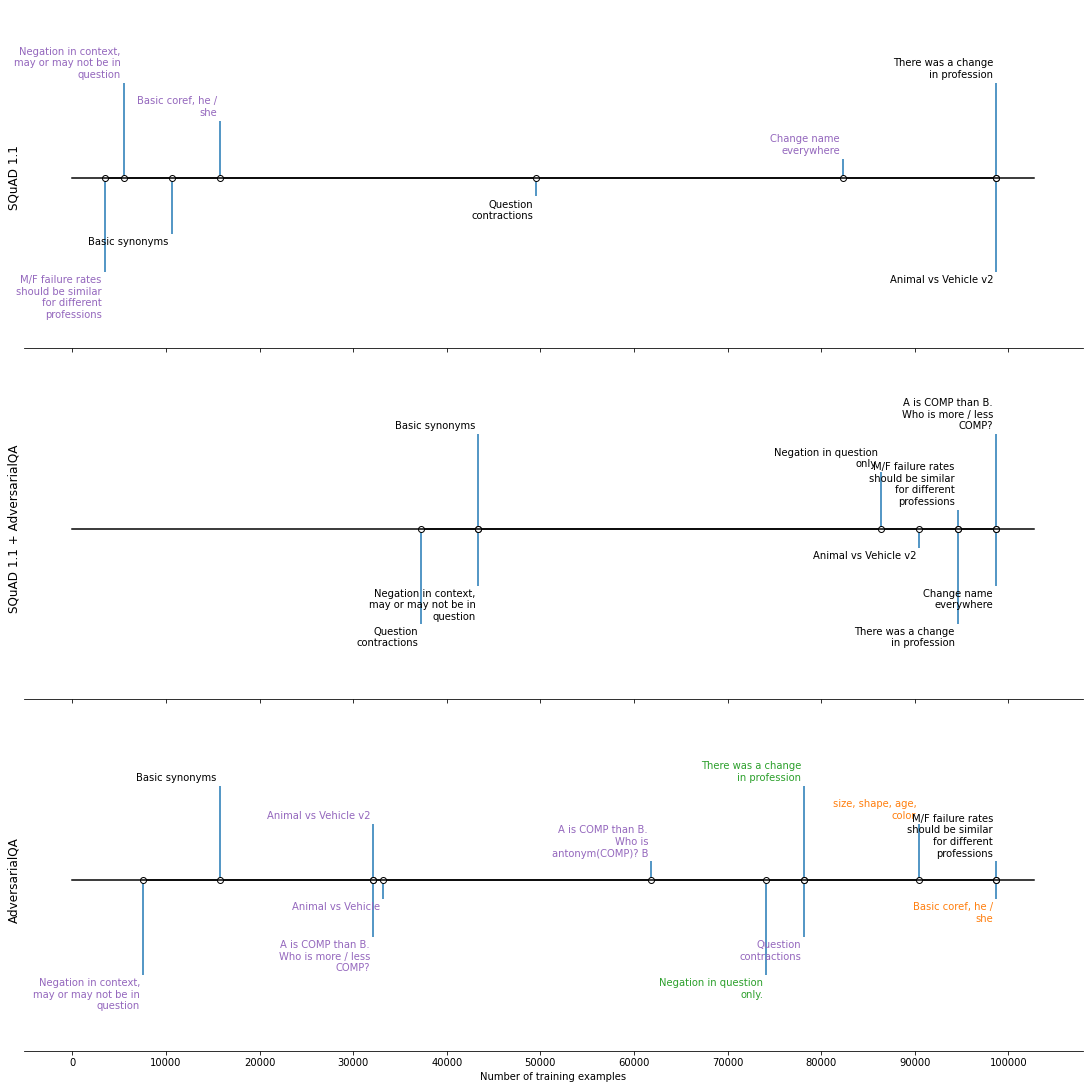

In [65]:
fig, ax = plt.subplots(3, 1, figsize=(15, 15), constrained_layout=True, sharex=True)

#============================#
# SQuAD                      #
#============================#

test_names = list(
    hierarchy_df[
        (hierarchy_df['model'] == 'SQuAD 1.1') &
        ((hierarchy_df['never_learned'] == 0) | (hierarchy_df['never_learned'] == -1))
    ]['test_name']
)

num_examples = list(
    hierarchy_df[
        (hierarchy_df['model'] == 'SQuAD 1.1') &
        ((hierarchy_df['never_learned'] == 0) | (hierarchy_df['never_learned'] == -1))
    ]['num_examples']
)

# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(num_examples)/6)))[:len(num_examples)]

ax[0].set_ylim(-9, 9)
ax[0].vlines(num_examples, 0, levels, color="tab:blue")  # The vertical stems.
ax[0].plot(num_examples, np.zeros_like(num_examples), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.
ax[0].plot([0, 3212*BATCH_SIZE], np.zeros_like([0, 3212*BATCH_SIZE]), color="k")  # Extend line to limits

# annotate lines
for i, (d, l, r) in enumerate(zip(num_examples, levels, test_names)):
    
    if r in list(learned_at_some_point_not_consistent_squad['test_name']):
        color = 'tab:purple'
    else:
        color = 'black'
    
    ax[0].annotate(
        "\n".join(wrap(f"{r}", 20)),
        xy=(d, l),
        xytext=(-3, np.sign(l)*3), 
        textcoords="offset points",
        horizontalalignment="right", # if i % 2 == 0 else "left",
        verticalalignment="bottom" if l > 0 else "top",
        color=color
    )

# remove y axis and spines
ax[0].set_yticklabels([])
ax[0].set_yticks([])
ax[0].spines[["left", "top", "right"]].set_visible(False)
ax[0].margins(y=0.1)


#============================#
# SQuAD + Adversarial QA     #
#============================#

test_names = list(
    hierarchy_df[
        (hierarchy_df['model'] == 'SQuAD 1.1 + AdversarialQA') &
        (hierarchy_df['never_learned'] == 0)
    ]['test_name']
)

num_examples = list(
    hierarchy_df[
        (hierarchy_df['model'] == 'SQuAD 1.1 + AdversarialQA') &
        (hierarchy_df['never_learned'] == 0)
    ]['num_examples']
)

# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(num_examples)/6)))[:len(num_examples)]

ax[1].set_ylim(-9, 9)
ax[1].vlines(num_examples, 0, levels, color="tab:blue")  # The vertical stems.
ax[1].plot(num_examples, np.zeros_like(num_examples), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.
ax[1].plot([0, 3212*BATCH_SIZE], np.zeros_like([0, 3212*BATCH_SIZE]), color="k")  # Extend line to limits

# annotate lines
for i, (d, l, r) in enumerate(zip(num_examples, levels, test_names)):
    
#     if r in learned_by_combined_not_squad:
#         color = 'tab:orange'
#     elif r in tests_learned_squad_before_combined:
#         color = 'tab:red'
#     elif r in tests_learned_combined_before_squad:
#         color = 'tab:green'
#     else:
#         color = 'black'
    
    ax[1].annotate(
        "\n".join(wrap(f"{r}", 20)),
        xy=(d, l),
        xytext=(-3, np.sign(l)*3), 
        textcoords="offset points",
        horizontalalignment="right", # if i % 2 == 0 else "left",
        verticalalignment="bottom" if l > 0 else "top",
#         color=color
    )

# remove y axis and spines
ax[1].set_yticklabels([])
ax[1].set_yticks([])
ax[1].spines[["left", "top", "right"]].set_visible(False)
ax[1].margins(y=0.1)

#============================#
# Adversarial QA             #
#============================#

test_names = list(
    hierarchy_df[
        (hierarchy_df['model'] == 'AdversarialQA') &
        ((hierarchy_df['never_learned'] == 0) | (hierarchy_df['never_learned'] == -1))
    ]['test_name']
)

num_examples = list(
    hierarchy_df[
        (hierarchy_df['model'] == 'AdversarialQA') &
        ((hierarchy_df['never_learned'] == 0) | (hierarchy_df['never_learned'] == -1))
    ]['num_examples']
)

# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(num_examples)/6)))[:len(num_examples)]

ax[2].set_ylim(-9, 9)
ax[2].vlines(num_examples, 0, levels, color="tab:blue")  # The vertical stems.
ax[2].plot(num_examples, np.zeros_like(num_examples), "-o",
        color="k", markerfacecolor="w")  # Baseline and markers on it.
ax[2].plot([0, 3212*BATCH_SIZE], np.zeros_like([0, 3212*BATCH_SIZE]), color="k")  # Extend line to limits

# annotate lines
for i, (d, l, r) in enumerate(zip(num_examples, levels, test_names)):
    
    if r in list(learned_at_some_point_not_consistent_adqa['test_name']):
        color = 'tab:purple'
    elif r in learned_by_adqa_only:
        color = 'tab:orange'
    elif r in tests_learned_adqa_after:
        color = 'tab:red'
    elif r in tests_learned_adqa_before:
        color = 'tab:green'
    else:
        color = 'black'
    
    ax[2].annotate(
        "\n".join(wrap(f"{r}", 20)),
        xy=(d, l),
        xytext=(-3, np.sign(l)*3), 
        textcoords="offset points",
        horizontalalignment="right", # if i % 2 == 0 else "left",
        verticalalignment="bottom" if l > 0 else "top",
        color=color
    )

# remove y axis and spines
ax[2].set_yticklabels([])
ax[2].set_yticks([])
ax[2].spines[["left", "top", "right"]].set_visible(False)
ax[2].set_xlabel('Number of training examples')
ax[2].margins(y=0.1)

ax[2].set_xticks(np.arange(0, 3212*BATCH_SIZE, 10000))

rows = ['SQuAD 1.1', 'SQuAD 1.1 + AdversarialQA', 'AdversarialQA']

for axi, row in zip(ax, rows):
    axi.set_ylabel(row, rotation=90, size='large')

plt.savefig('reports/figures/checklist-hierarchy-with-adqa.pdf')
plt.show()